In [2]:
# Importing the libraries
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder('/kaggle/input/data-set2/data_2', transform=transform)
print(len(full_dataset))

1200


In [4]:
train_size = int(0.8 * len(full_dataset))

validation_size = len(full_dataset) - train_size
train_dataset, validation_dataset = random_split(full_dataset, [train_size, validation_size])

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [6]:
googlenet = models.googlenet(pretrained=False)

googlenet.fc = torch.nn.Linear(googlenet.fc.in_features, 20)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet.to(device)
device

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


device(type='cpu')

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)

In [10]:
# Set the number of epochs
epochs = 10

for epoch in range(epochs):
    googlenet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # Validation loop
    googlenet.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Loss: {validation_loss/len(validation_loader)}, Accuracy: {100 * correct / total}%')

Epoch 1/10, Loss: 0.29838120117783545
Validation Loss: 1.9709728956222534, Accuracy: 49.583333333333336%
Epoch 2/10, Loss: 0.26331224317351976
Validation Loss: 2.404933750629425, Accuracy: 43.333333333333336%
Epoch 3/10, Loss: 0.1902131234606107
Validation Loss: 2.118081346154213, Accuracy: 52.083333333333336%
Epoch 4/10, Loss: 0.1896293600400289
Validation Loss: 2.013731151819229, Accuracy: 52.083333333333336%
Epoch 5/10, Loss: 0.14831012847522895
Validation Loss: 2.033573269844055, Accuracy: 48.75%
Epoch 6/10, Loss: 0.13442399650812148
Validation Loss: 2.017836093902588, Accuracy: 52.083333333333336%
Epoch 7/10, Loss: 0.09458610800405344
Validation Loss: 1.8590768724679947, Accuracy: 56.25%
Epoch 8/10, Loss: 0.07002132168660562
Validation Loss: 1.7454922497272491, Accuracy: 56.666666666666664%
Epoch 9/10, Loss: 0.07170815244317055
Validation Loss: 1.6468746215105057, Accuracy: 58.333333333333336%
Epoch 10/10, Loss: 0.06819920130074024
Validation Loss: 1.869301751255989, Accuracy: 56.

**ANALYSIS**

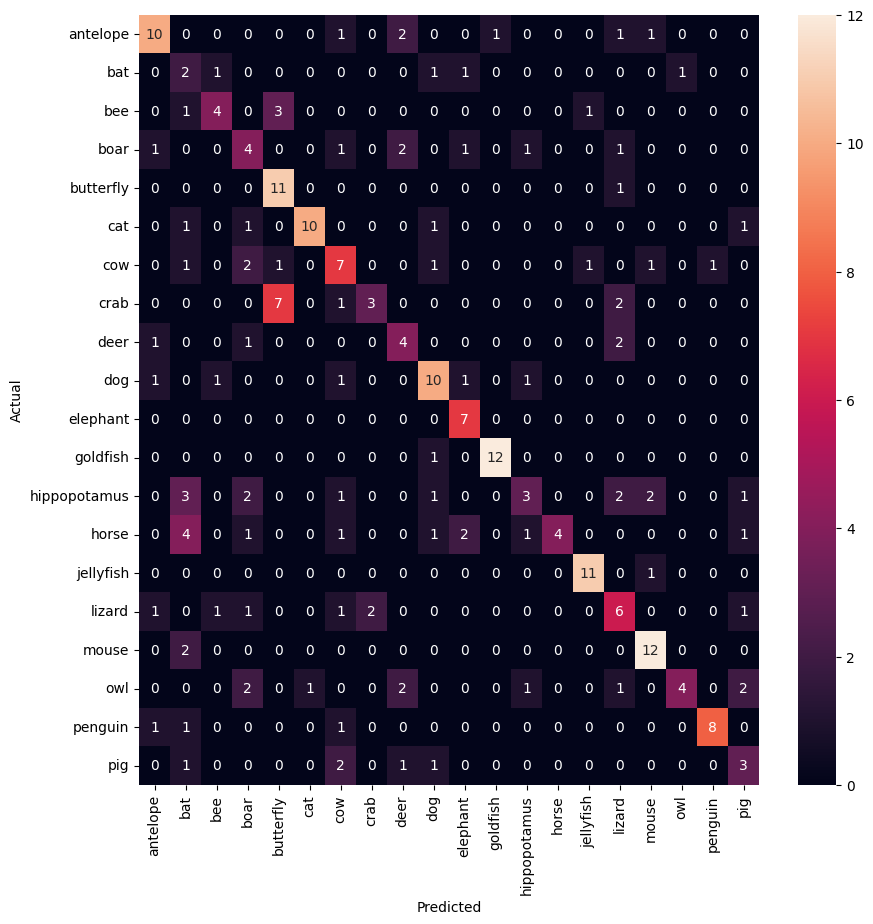

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = googlenet(images)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=validation_dataset.dataset.classes,
            yticklabels=validation_dataset.dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [12]:
from sklearn.metrics import classification_report

all_preds = np.array(predlist)
all_labels = np.array(lbllist)

class_report = classification_report(all_labels, all_preds, target_names=full_dataset.classes)
print(class_report)

              precision    recall  f1-score   support

    antelope       0.67      0.62      0.65        16
         bat       0.12      0.33      0.18         6
         bee       0.57      0.44      0.50         9
        boar       0.29      0.36      0.32        11
   butterfly       0.50      0.92      0.65        12
         cat       0.91      0.71      0.80        14
         cow       0.41      0.47      0.44        15
        crab       0.60      0.23      0.33        13
        deer       0.36      0.50      0.42         8
         dog       0.59      0.67      0.62        15
    elephant       0.58      1.00      0.74         7
    goldfish       0.92      0.92      0.92        13
hippopotamus       0.43      0.20      0.27        15
       horse       1.00      0.27      0.42        15
   jellyfish       0.85      0.92      0.88        12
      lizard       0.38      0.46      0.41        13
       mouse       0.71      0.86      0.77        14
         owl       0.80    